### Клонирование репозитория с логами для их последующего анализа

In [ ]:
import os.path

if not os.path.isdir("./loghub/"):
    !git clone https://github.com/logpai/loghub

Cloning into 'loghub'...
remote: Enumerating objects: 563, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 563 (delta 58), reused 54 (delta 48), pack-reused 476
Receiving objects: 100% (563/563), 7.32 MiB | 14.64 MiB/s, done.
Resolving deltas: 100% (259/259), done.


### Задание регулярного выражения для парсинга логов

Для примера возьмем строчку из логов Hadoop:

```
2015-10-18 18:01:49,228 INFO [main] org.apache.hadoop.mapreduce.v2.app.MRAppMaster: Using mapred newApiCommitter.
```

Регулярное выражение извлекает все поля записи лога и делит его на следующие группы:

- Дата в формате `YYYY-MM-DD`: `\d{4}-\d{2}-\d{2}`
- Время в формате `HH:MM:SS,SSS`: `\d{2}:\d{2}:\d{2}\,\d{3}`
- Уровень логирования - 6 [возможных](https://hadoop.apache.org/docs/r2.7.0/hadoop-project-dist/hadoop-common/CommandsManual.html) типов (`FATAL`, `ERROR`, `WARN`, `INFO`, `DEBUG` и `TRACE`): `(INFO|WARN|ERROR|FATAL|DEBUG|TRACE)`
- Процесс - имя процесса, создавшего запись в логе, заключенное в фигурные скобки: `\[.*\]`
- Компонент - имя компонента, создавшего запись в логе, отделённое от сообщения двоеточием: `.*?:`
- Сообщение - непосредственное содержание записи, все символы до конца строки: `(.*)`

In [ ]:
import re

pattern = r'(\d{4}-\d{2}-\d{2})\s(\d{2}:\d{2}:\d{2},\d{3})\s(INFO|WARN|ERROR|FATAL|DEBUG|TRACE)\s(\[.*\])\s(.*?:)\s(.*)'

### Инициализация базы данных

В среде выполнения создаётся каталог `./db`, где будет храниться файл базы данных SQLite

In [ ]:
if not os.path.isdir("./db/"):
  os.makedirs("./db/")

In [ ]:
import sqlite3

db_path = './db/log-analysis.db'

connection = sqlite3.connect(db_path)
# создание курсора
cursor = connection.cursor()

cursor.execute("DROP TABLE IF EXISTS logs")
# создание таблицы
cursor.execute("CREATE TABLE logs (id INTEGER PRIMARY KEY AUTOINCREMENT, datetime text, loglvl text, process text, component text, message text)")

# сохранение изменений
connection.commit()
# закрытие курсора
cursor.close()
# закрытие подключения к БД
connection.close()

### Парсинг лога и сохранение записей в БД

In [ ]:
# подключение к БД и создание курсора
connection = sqlite3.connect(db_path)
cursor = connection.cursor()

# очистка таблицы для избежание дублирования данных
cursor.execute("DELETE FROM logs")

# парсинг файла с логом
with open('./loghub/Hadoop/Hadoop_2k.log', 'r', encoding='utf-8') as log_file:
    for line in log_file:
        log_match = re.match(pattern, line)
        if log_match:
            date = log_match.group(1)
            time = log_match.group(2)
            datetime = f"{date} {time}" # формирование полной даты
            loglvl = log_match.group(3)
            process = log_match.group(4)
            component = log_match.group(5)
            message = log_match.group(6)
            values = (datetime, loglvl, process, component, message)
            sql = "INSERT INTO logs (datetime, loglvl, process, component, message) VALUES (?, ?, ?, ?, ?)"
            cursor.execute(sql, values) # запись данных в БД

connection.commit()
cursor.close()
connection.close()

### Чтение записей из БД

In [ ]:
import pandas as pd

# подключение к БД и создание курсора
connection = sqlite3.connect(db_path)
cursor = connection.cursor()

# выборка всех записей из таблицы
cursor.execute("SELECT * FROM logs")
rows = cursor.fetchall()

cursor.close()
connection.close()

# запись данных в объект DataFrame
log_df = pd.DataFrame(rows, columns=("id", "Date", "Level", "Process Name", "Component", "Message"))
log_df

,id,Date,Level,Process Name,Component,Message
0,1,"2015-10-18 18:01:47,978",INFO,[main],org.apache.hadoop.mapreduce.v2.app.MRAppMaster:,Created MRAppMaster for application appattempt...
1,2,"2015-10-18 18:01:48,963",INFO,[main],org.apache.hadoop.mapreduce.v2.app.MRAppMaster:,Executing with tokens:
2,3,"2015-10-18 18:01:48,963",INFO,[main],org.apache.hadoop.mapreduce.v2.app.MRAppMaster:,"Kind: YARN_AM_RM_TOKEN, Service: , Ident: (app..."
3,4,"2015-10-18 18:01:49,228",INFO,[main],org.apache.hadoop.mapreduce.v2.app.MRAppMaster:,Using mapred newApiCommitter.
4,5,"2015-10-18 18:01:50,353",INFO,[main],org.apache.hadoop.mapreduce.v2.app.MRAppMaster:,OutputCommitter set in config null
...,...,...,...,...,...,...
1995,1996,"2015-10-18 18:10:54,202",WARN,[LeaseRenewer:msrabi@msra-sa-41:9000],org.apache.hadoop.ipc.Client:,Address change detected. Old: msra-sa-41/10.19...
1996,1997,"2015-10-18 18:10:54,202",WARN,[LeaseRenewer:msrabi@msra-sa-41:9000],org.apache.hadoop.hdfs.LeaseRenewer:,Failed to renew lease for [DFSClient_NONMAPRED...
1997,1998,"2015-10-18 18:10:54,546",INFO,[RMCommunicator Allocator],org.apache.hadoop.ipc.Client:,Retrying connect to server: msra-sa-41:8030. A...
1998,1999,"2015-10-18 18:10:54,546",ERROR,[RMCommunicator Allocator],org.apache.hadoop.mapreduce.v2.app.rm.RMContai...,ERROR IN CONTACTING RM.


from matplotlib import pyplot as plt
log_df['id'].plot(kind='hist', bins=20, title='id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
log_df.groupby('Level').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['id']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'id'}, axis=1)
              .sort_values('id', ascending=True))
  xs = counted['id']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = log_df.sort_values('id', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Level')):
  _plot_series(series, series_name, i)
  fig.legend(title='Level', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('id')
_ = plt.ylabel('count()')

### Построение графика распределения уровней логирования

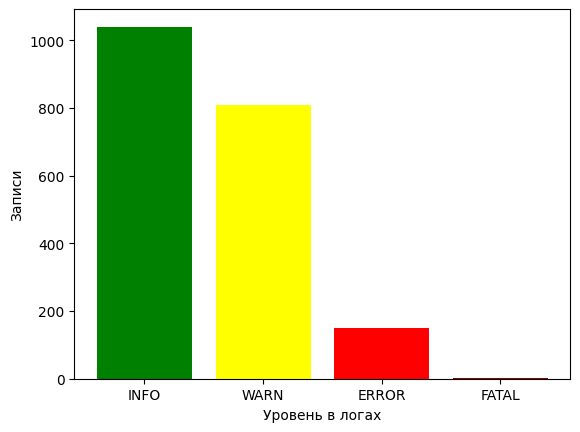

In [ ]:
import matplotlib.pyplot as plt

log_level_distrib = log_df['Level'].value_counts()

x = log_level_distrib.keys()
y = log_level_distrib.values

# более подробные заголовки для графика
verbose_xticks = ["INFO", "WARN", "ERROR", "FATAL", "DEBUG", "TRACE"]

plt.xticks([0,1,2,3,4,5], verbose_xticks)
plt.xticks(rotation=0)
plt.xlabel('Уровень в логах')
plt.ylabel('Записи')
plt.bar(x,y, color = ['green', 'yellow', 'red', 'darkred', 'blue', 'grey'])

plt.show()

### Построение графика распределения записей по топ-5 процессам, создавшим запись

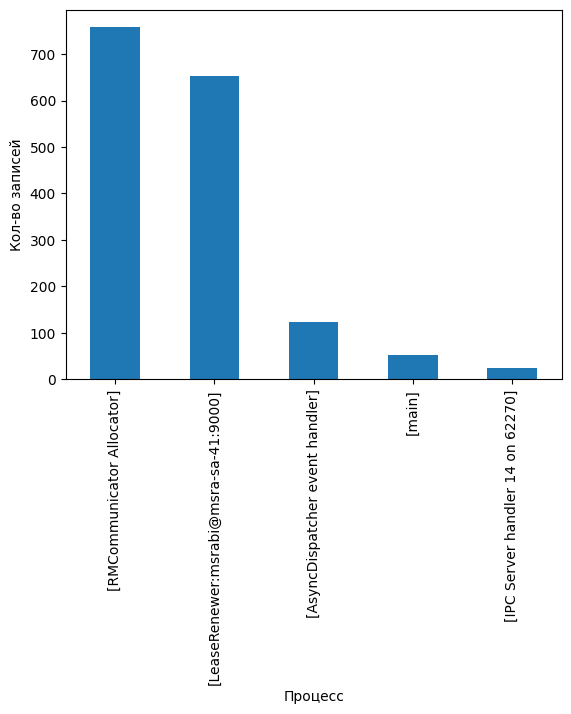

In [ ]:
components_distrib = log_df['Process Name'].value_counts()[:5]

components_distrib.plot(kind='bar')

plt.xlabel('Процесс')
plt.ylabel('Кол-во записей')
plt.show()

### Построение графика распределения появления ошибок за некоторое время логирования

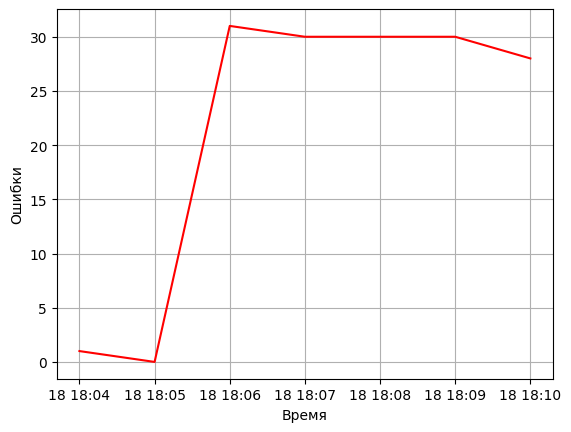

In [ ]:
# выборка записей-предупреждений
warning_df = log_df[log_df['Level'] == 'ERROR'].copy()

# конвертация времени в объект datetime
warning_df['Date'] = pd.to_datetime(warning_df['Date'])

# группировка по времени
warning_count = warning_df.groupby('Date').size()

# ресэмплинг для группировки по целым секундам для наглядности
warning_count = warning_count.resample('T').sum()
warning_count = warning_count.fillna(0)

plt.plot(warning_count.index, warning_count.values, linestyle='-', color='r')
plt.xlabel('Время')
plt.ylabel('Ошибки')
plt.grid(True)
plt.show()